# Identifying cohabiting contributors 

In this exercise, we will look throughout the database and try to identify households where multiple individuals have made contributions while cohabiting.

To do this, we will do the following:

    1- Build a dictionary of all normalized addresses. Associate every address with the set of all its identities.
    2- For those with multiple identities, do further processing.





Problem: the normalized attributes file doesn't contain normalized addresses.

In [21]:
import pandas as pd
from disambiguation.core import Database
from disambiguation.core import Person

from disambiguation.core import utils
from disambiguation import config
import json
from pprint import pprint

In [2]:
idm = Database.IdentityManager('USA')
idm.table_name_identities
idm.fetch_dict_id_2_identity()

Table 'identities_v5' exists.
Table 'identities_adjacency_v5' exists.
Table 'linked_identities_v5' exists.
select id,identity from identities_v5;


In [3]:
idm.fetch_dict_identity_2_id()

select id,identity from identities_v5;


In [4]:
retriever = Database.FecRetriever('usa_combined_v2',
                                  query_fields=['id', 'NAME','CONTRIBUTOR_STREET_1'
                                                ,'ZIP_CODE', 'TRANSACTION_AMT', 'TRANSACTION_DT', 'CMTE_ID']
                                 , where_clause=' WHERE CONTRIBUTOR_STREET_1 IS NOT NULL ')

In [5]:
retriever.retrieve()

In [6]:
list_records = retriever.getRecords()
print len(list_records)

11508004


In [7]:
dict_addresses = {}


for r in list_records:
    address, zipcode = r['CONTRIBUTOR_STREET_1'], r['ZIP_CODE']
    address_full = (zipcode[:5], address)
    rid = r.id
    try:
        dict_addresses[address_full].append(rid)
    except:
        dict_addresses[address_full] = [rid]

In [8]:
len(dict_addresses)

4025475

In [9]:
dict_identities = {}
for address, list_rids in dict_addresses.iteritems():
    set_identities = {idm.get_compound_identity(rid)[0] for rid in list_rids}
    if len(set_identities) > 1:
        dict_identities[address] = set_identities
    
    

dict_linked_identities not loaded. Loading now...
select identity1, identity2 from linked_identities_v5;


In [10]:
print len(dict_identities)

541894


In [11]:
print idm.get_ids('OH-34442')
print idm.get_ids('GA-36500')

[10639568]
[8305739, 8486565, 8839925, 8977749, 11969509, 13439119]


In [12]:
print idm.get_ids('CA-459207')
print idm.get_ids('CA-459208')

[4302189, 5809001, 6407902, 7695132]
[4302191, 14867480]


In [14]:
record_retriever = Database.FecRetrieverByID('usa_combined_v2')
def load_compound_person(compound_identity):
    '''
    Given a compound identity, load all its records and
    generate a Person object from them.
    '''
    s = compound_identity
    list_rids = [rid for identity in s.split('|') for rid in idm.get_ids(identity)]
#     f.write(" ".join([str(rid) for rid in list_rids]) + "\n")
    record_retriever.retrieve(list_rids)
    list_records = record_retriever.getRecords()
    
    p = Person.Person(list_records)
    return p


def get_date_range(p):
    '''
    Given a Person object, return a tuple consisting
    of the first and last date of its contributions.
    '''
    list_dates = [r['TRANSACTION_DT'] for r in p.set_of_records]
    list_dates.sort()
    return (list_dates[0], list_dates[-1])

def get_transactions(p):
    '''
    Extract and return the list of transactions of the
    given Person object.
    '''
    return [(r.id, r['TRANSACTION_DT'], r['TRANSACTION_AMT'], r['CMTE_ID']) for r in p.set_of_records]


In [15]:
counter = 0

# Number of cases where there are at least two people 
# with the same last name in the same household.
counter_2_people_same_last = 0

counter_2_people = 0


with open('/nfs/home/navid/data/FEC/cohabitation/cohabitation_2.txt', 'w', buffering = 100) as outfile:
    for address, set_identities in dict_identities.iteritems():
    #     print address, set_identities
        if len(set_identities) > 10: continue

        dict_persons = {}

        list_names = []
        for compound_identity in set_identities:
            try:
                p = load_compound_person(compound_identity)
                name = p.get_dominant_attribute('NAME')

                if name: 
                    list_names.append(name)
                    dict_persons[compound_identity] = {'name': name,
                                                        'daterange': get_date_range(p),
                                                       'transactions' : get_transactions(p)}

            except Exception as e:
                print "ERROR OCCURRED", e

        if counter % 1000 == 0:
            print counter

        try:
            lastnames = set([utils.splitname(name)[0] for name in list_names])
        except: 
            print "ERORORORORORORORORORRORORO"
            break
            
        if len(list_names) == 2: 
            counter_2_people += 1

        if len(lastnames) < len(list_names):
            counter_2_people_same_last += 1
            outfile.write(json.dumps(dict_persons) + "\n")

        if counter > 1000000:
            break
        counter += 1

print counter
print counter_2_people
print counter_2_people_same_last

0
inserting...
done.
1000
2000
3000
4000
5000
6000

/nfs/home/navid/src/FEC-1/src/disambiguation/core/Database.py:62: Warning: Unknown table 'tmp_LuSk23cENYkSNUUf42Ak'
  cur.execute(query)
/nfs/home/navid/src/FEC-1/src/disambiguation/core/Database.py:62: Warning: Unknown table 'tmp_ZBeeI5fw9G8JERl7MV1O'
  cur.execute(query)



inserting...
done.
7000
8000
inserting...
done.
9000

/nfs/home/navid/src/FEC-1/src/disambiguation/core/Database.py:62: Warning: Unknown table 'tmp_jmJeG3kAfDfZcQ0RZdot'
  cur.execute(query)
/nfs/home/navid/src/FEC-1/src/disambiguation/core/Database.py:62: Warning: Unknown table 'tmp_zjoD29vfisQL29BdL13S'
  cur.execute(query)



inserting...
done.
10000
inserting...
done.
11000
12000

/nfs/home/navid/src/FEC-1/src/disambiguation/core/Database.py:62: Warning: Unknown table 'tmp_hY9hbj2j0IKwh2JmJ7ES'
  cur.execute(query)
/nfs/home/navid/src/FEC-1/src/disambiguation/core/Database.py:62: Warning: Unknown table 'tmp_6qZ2DuhX3zFELYnwpbMh'
  cur.execute(query)



inserting...
done.
13000
14000
15000
16000
17000
18000
inserting...
done.
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000

/nfs/home/navid/src/FEC-1/src/disambiguation/core/Database.py:62: Warning: Unknown table 'tmp_JjBWgoVeUG6Ins2fieqK'
  cur.execute(query)
/nfs/home/navid/src/FEC-1/src/disambiguation/core/Database.py:62: Warning: Unknown table 'tmp_cwP2s5acSHtoTSpVWR6g'
  cur.execute(query)



inserting...
done.
31000
32000
33000
inserting...
done.
34000
35000
36000
37000
38000
39000
40000

/nfs/home/navid/src/FEC-1/src/disambiguation/core/Database.py:62: Warning: Unknown table 'tmp_4d4NxhHsc92PltFC2kiQ'
  cur.execute(query)
/nfs/home/navid/src/FEC-1/src/disambiguation/core/Database.py:62: Warning: Unknown table 'tmp_JHuEMYQxcX204E7zXM0o'
  cur.execute(query)



inserting...
done.
41000
42000
43000
44000
inserting...
done.
45000

/nfs/home/navid/src/FEC-1/src/disambiguation/core/Database.py:62: Warning: Unknown table 'tmp_j3jMbcUBLtrePQSOwBGF'
  cur.execute(query)
/nfs/home/navid/src/FEC-1/src/disambiguation/core/Database.py:62: Warning: Unknown table 'tmp_TO7dri3vjDBmB9kLO4gz'
  cur.execute(query)



inserting...
done.
46000
47000
inserting...
done.
48000
49000
50000
51000
52000
53000
54000

/nfs/home/navid/src/FEC-1/src/disambiguation/core/Database.py:62: Warning: Unknown table 'tmp_LUjH7p66RG2O4rrPjPHQ'
  cur.execute(query)
/nfs/home/navid/src/FEC-1/src/disambiguation/core/Database.py:62: Warning: Unknown table 'tmp_5cUwAwMhzZI4L3tbqEJ4'
  cur.execute(query)



inserting...
done.
55000
56000
57000
58000
inserting...
done.

/nfs/home/navid/src/FEC-1/src/disambiguation/core/Database.py:62: Warning: Unknown table 'tmp_VplaOCOMtGLu4zhH9VB9'
  cur.execute(query)
/nfs/home/navid/src/FEC-1/src/disambiguation/core/Database.py:62: Warning: Unknown table 'tmp_KUpU9Eed3cedet9xQFUi'
  cur.execute(query)



inserting...
done.
59000
60000
61000
62000
inserting...
done.
63000
64000
65000
66000
67000

/nfs/home/navid/src/FEC-1/src/disambiguation/core/Database.py:62: Warning: Unknown table 'tmp_NGSFSQVuB8aMRhwXufQW'
  cur.execute(query)
/nfs/home/navid/src/FEC-1/src/disambiguation/core/Database.py:62: Warning: Unknown table 'tmp_6woIv3HrfXSeruuX0jSu'
  cur.execute(query)



inserting...
done.
68000
69000
70000
71000
72000
73000
74000
75000
inserting...
done.
76000
77000
78000
79000
80000
81000
82000
83000

/nfs/home/navid/src/FEC-1/src/disambiguation/core/Database.py:62: Warning: Unknown table 'tmp_ulnJdBt1rMWNJ785mEa3'
  cur.execute(query)
/nfs/home/navid/src/FEC-1/src/disambiguation/core/Database.py:62: Warning: Unknown table 'tmp_JfC76zVJRVTFDco6GpdA'
  cur.execute(query)



inserting...
done.
84000
inserting...
done.
85000
86000

/nfs/home/navid/src/FEC-1/src/disambiguation/core/Database.py:62: Warning: Unknown table 'tmp_qkvoHopg6XPHGdi9xUGb'
  cur.execute(query)
/nfs/home/navid/src/FEC-1/src/disambiguation/core/Database.py:62: Warning: Unknown table 'tmp_cBLIba3Rv2GFQBjwjelc'
  cur.execute(query)



inserting...
done.
87000
inserting...
done.
88000
89000

/nfs/home/navid/src/FEC-1/src/disambiguation/core/Database.py:62: Warning: Unknown table 'tmp_BWX8IpPs0hl5EuYB6v4n'
  cur.execute(query)
/nfs/home/navid/src/FEC-1/src/disambiguation/core/Database.py:62: Warning: Unknown table 'tmp_KLME4S1efwjmcGMRuOBE'
  cur.execute(query)



inserting...
done.
90000
inserting...
done.
91000
92000
93000
94000

/nfs/home/navid/src/FEC-1/src/disambiguation/core/Database.py:62: Warning: Unknown table 'tmp_p5HdgbbBVhmc8JDg8uAU'
  cur.execute(query)
/nfs/home/navid/src/FEC-1/src/disambiguation/core/Database.py:62: Warning: Unknown table 'tmp_LX79TUOLI4N8qKDoN6ra'
  cur.execute(query)



inserting...
done.
95000
96000
97000
inserting...
done.
98000
99000

/nfs/home/navid/src/FEC-1/src/disambiguation/core/Database.py:62: Warning: Unknown table 'tmp_enosKbda1Woq7mX5iEhJ'
  cur.execute(query)
/nfs/home/navid/src/FEC-1/src/disambiguation/core/Database.py:62: Warning: Unknown table 'tmp_Y8S31UwgOZCumNDouk29'
  cur.execute(query)



inserting...
done.
100000
inserting...
done.
101000
102000
103000
104000
105000
106000
107000
108000

/nfs/home/navid/src/FEC-1/src/disambiguation/core/Database.py:62: Warning: Unknown table 'tmp_7OCWFpSGq7rQCedBFxdE'
  cur.execute(query)
/nfs/home/navid/src/FEC-1/src/disambiguation/core/Database.py:62: Warning: Unknown table 'tmp_kOm5bcIm5HmWYvAeCwiN'
  cur.execute(query)



inserting...
done.
109000
110000
111000
112000
113000
114000
115000
116000
inserting...
done.
117000

/nfs/home/navid/src/FEC-1/src/disambiguation/core/Database.py:62: Warning: Unknown table 'tmp_51PWFPlUwSeYrtfhH2bA'
  cur.execute(query)
/nfs/home/navid/src/FEC-1/src/disambiguation/core/Database.py:62: Warning: Unknown table 'tmp_i3gawCpMJJbGfApceoMd'
  cur.execute(query)



inserting...
done.
118000
inserting...
done.
119000

/nfs/home/navid/src/FEC-1/src/disambiguation/core/Database.py:62: Warning: Unknown table 'tmp_4W6HYfMALFgWUigqttQV'
  cur.execute(query)
/nfs/home/navid/src/FEC-1/src/disambiguation/core/Database.py:62: Warning: Unknown table 'tmp_7F4MxUQfc7nO1V4M08QZ'
  cur.execute(query)



inserting...
done.
120000
121000
122000
123000
inserting...
done.
124000
125000
126000
127000

/nfs/home/navid/src/FEC-1/src/disambiguation/core/Database.py:62: Warning: Unknown table 'tmp_hLiPUW15N6WaMSixfehx'
  cur.execute(query)
/nfs/home/navid/src/FEC-1/src/disambiguation/core/Database.py:62: Warning: Unknown table 'tmp_nxXfzcEiHNpAZL3aTJbj'
  cur.execute(query)



inserting...
done.
128000
129000
130000
131000
132000
133000
inserting...
done.
134000
135000
136000
137000
138000
139000

/nfs/home/navid/src/FEC-1/src/disambiguation/core/Database.py:62: Warning: Unknown table 'tmp_Eqj0aglS5TP9OXKumHeq'
  cur.execute(query)
/nfs/home/navid/src/FEC-1/src/disambiguation/core/Database.py:62: Warning: Unknown table 'tmp_HSCZHVP6LL9da69HZqvU'
  cur.execute(query)



inserting...
done.
140000
141000
142000
143000
144000
145000
146000
147000
148000
149000
150000
151000
152000
153000
inserting...
done.
154000
155000
156000

/nfs/home/navid/src/FEC-1/src/disambiguation/core/Database.py:62: Warning: Unknown table 'tmp_FqB931lmreJSNK7n81Ij'
  cur.execute(query)
/nfs/home/navid/src/FEC-1/src/disambiguation/core/Database.py:62: Warning: Unknown table 'tmp_WKkP9YB3jcb9Rjx2PVuj'
  cur.execute(query)



inserting...
done.
157000
158000
159000
160000
161000
162000
163000
inserting...
done.
164000
165000
166000
167000
168000
169000
170000
171000
172000
173000
174000

/nfs/home/navid/src/FEC-1/src/disambiguation/core/Database.py:62: Warning: Unknown table 'tmp_9CdGEJYXJiIukHqB0efh'
  cur.execute(query)
/nfs/home/navid/src/FEC-1/src/disambiguation/core/Database.py:62: Warning: Unknown table 'tmp_YEximDZZLSjDrZzxuI8V'
  cur.execute(query)



inserting...
done.
175000
176000
177000
178000
179000
180000
inserting...
done.

/nfs/home/navid/src/FEC-1/src/disambiguation/core/Database.py:62: Warning: Unknown table 'tmp_o1P7STIzp92pT9AnswUp'
  cur.execute(query)
/nfs/home/navid/src/FEC-1/src/disambiguation/core/Database.py:62: Warning: Unknown table 'tmp_XJXs0Q91ao3EO8830Ol5'
  cur.execute(query)



inserting...
done.
181000
182000
183000
184000
inserting...
done.
185000

/nfs/home/navid/src/FEC-1/src/disambiguation/core/Database.py:62: Warning: Unknown table 'tmp_q1Yfkr2RO37HmeDIRzoV'
  cur.execute(query)
/nfs/home/navid/src/FEC-1/src/disambiguation/core/Database.py:62: Warning: Unknown table 'tmp_sKNpEYKBY8pXooLqWBtF'
  cur.execute(query)



inserting...
done.
186000
inserting...
done.
187000
188000
189000
190000
191000
192000
193000

/nfs/home/navid/src/FEC-1/src/disambiguation/core/Database.py:62: Warning: Unknown table 'tmp_YYFcC0RSNO9tX2FjiBYU'
  cur.execute(query)
/nfs/home/navid/src/FEC-1/src/disambiguation/core/Database.py:62: Warning: Unknown table 'tmp_dG5SlkEqfKni9af4vNc8'
  cur.execute(query)



inserting...
done.
194000
195000
196000
197000
inserting...
done.
198000
199000
200000
201000
202000

/nfs/home/navid/src/FEC-1/src/disambiguation/core/Database.py:62: Warning: Unknown table 'tmp_wxJG1zwwEBWrM5aJucAZ'
  cur.execute(query)
/nfs/home/navid/src/FEC-1/src/disambiguation/core/Database.py:62: Warning: Unknown table 'tmp_mXF70hXu8AEW4m96o6Tt'
  cur.execute(query)



inserting...
done.
203000
inserting...
done.
204000
205000
206000
207000
208000

/nfs/home/navid/src/FEC-1/src/disambiguation/core/Database.py:62: Warning: Unknown table 'tmp_ooCeXL8eZdZajoBOcqb5'
  cur.execute(query)
/nfs/home/navid/src/FEC-1/src/disambiguation/core/Database.py:62: Warning: Unknown table 'tmp_uHhYRdrmkmqK5COcIv4E'
  cur.execute(query)



inserting...
done.
209000
210000
211000
212000
213000
214000
215000
216000
217000
218000
219000
inserting...
done.
220000
221000
222000

/nfs/home/navid/src/FEC-1/src/disambiguation/core/Database.py:62: Warning: Unknown table 'tmp_F2FghoRYEuP5SQvQsO9J'
  cur.execute(query)
/nfs/home/navid/src/FEC-1/src/disambiguation/core/Database.py:62: Warning: Unknown table 'tmp_droeKddQb6XsfLDwCuqV'
  cur.execute(query)



inserting...
done.
223000
224000
225000
inserting...
done.
226000
227000
228000
229000
230000
231000
232000
233000
234000
235000
236000
237000
238000

/nfs/home/navid/src/FEC-1/src/disambiguation/core/Database.py:62: Warning: Unknown table 'tmp_EU5nFASE8iMXbzrxzKva'
  cur.execute(query)
/nfs/home/navid/src/FEC-1/src/disambiguation/core/Database.py:62: Warning: Unknown table 'tmp_LevrzMD8cZnHgUMlSZtE'
  cur.execute(query)



inserting...
done.
239000
240000
241000
242000
243000
244000
245000
246000
247000
248000
249000
250000
251000
252000
253000
254000
inserting...
done.
255000
256000
257000
258000

/nfs/home/navid/src/FEC-1/src/disambiguation/core/Database.py:62: Warning: Unknown table 'tmp_9LCzKK8n0wbqzYD8Cf8d'
  cur.execute(query)
/nfs/home/navid/src/FEC-1/src/disambiguation/core/Database.py:62: Warning: Unknown table 'tmp_PgHRpLg0Dx4QdtocUk1U'
  cur.execute(query)



inserting...
done.
259000
260000
261000
262000
inserting...
done.
263000
264000
265000

/nfs/home/navid/src/FEC-1/src/disambiguation/core/Database.py:62: Warning: Unknown table 'tmp_Yjg7BH0H4FHa3IbxuNfW'
  cur.execute(query)
/nfs/home/navid/src/FEC-1/src/disambiguation/core/Database.py:62: Warning: Unknown table 'tmp_WWJZDdj0qhukotLR1T5X'
  cur.execute(query)



inserting...
done.
266000
267000
268000
269000
270000
inserting...
done.
271000

/nfs/home/navid/src/FEC-1/src/disambiguation/core/Database.py:62: Warning: Unknown table 'tmp_SdgGLnNAdxkLk5MbZhIa'
  cur.execute(query)
/nfs/home/navid/src/FEC-1/src/disambiguation/core/Database.py:62: Warning: Unknown table 'tmp_z0U4vKqKfrcIJucWljR5'
  cur.execute(query)



inserting...
done.
272000
273000
274000
275000
276000
277000
278000
inserting...
done.
279000
280000
281000

/nfs/home/navid/src/FEC-1/src/disambiguation/core/Database.py:62: Warning: Unknown table 'tmp_nU6ak1H47dBQKjf2nSjX'
  cur.execute(query)
/nfs/home/navid/src/FEC-1/src/disambiguation/core/Database.py:62: Warning: Unknown table 'tmp_Ae17ctnaIi5lOE9N613r'
  cur.execute(query)



inserting...
done.
282000
inserting...

/nfs/home/navid/src/FEC-1/src/disambiguation/core/Database.py:62: Warning: Unknown table 'tmp_9gjPMxNJHL9PYsfcjSw8'
  cur.execute(query)
/nfs/home/navid/src/FEC-1/src/disambiguation/core/Database.py:62: Warning: Unknown table 'tmp_dFxsD4TtjuDjveTBDaJq'
  cur.execute(query)



done.
inserting...
done.
283000
inserting...
done.
284000
285000
286000
287000
288000

/nfs/home/navid/src/FEC-1/src/disambiguation/core/Database.py:62: Warning: Unknown table 'tmp_umUnooe9P5YpNSNtauuU'
  cur.execute(query)
/nfs/home/navid/src/FEC-1/src/disambiguation/core/Database.py:62: Warning: Unknown table 'tmp_U0RkPac1rxCk1DDzIawH'
  cur.execute(query)



inserting...
done.
289000
290000
291000
292000
293000
294000
295000
296000
297000
298000
299000
300000
inserting...
done.
301000
302000
303000

/nfs/home/navid/src/FEC-1/src/disambiguation/core/Database.py:62: Warning: Unknown table 'tmp_pIgS2CMhDYAPZwoRGX0X'
  cur.execute(query)
/nfs/home/navid/src/FEC-1/src/disambiguation/core/Database.py:62: Warning: Unknown table 'tmp_fSgIpnvYZBU1cnSU4fio'
  cur.execute(query)



inserting...
done.
304000
305000
306000
inserting...
done.
307000
308000
309000
310000
311000
312000

/nfs/home/navid/src/FEC-1/src/disambiguation/core/Database.py:62: Warning: Unknown table 'tmp_zlPrLR7wPWjaiSTQFR6L'
  cur.execute(query)
/nfs/home/navid/src/FEC-1/src/disambiguation/core/Database.py:62: Warning: Unknown table 'tmp_nq5ImeQtiA0x0WfGfjgB'
  cur.execute(query)



inserting...
done.
313000
314000
315000
inserting...
done.
316000

/nfs/home/navid/src/FEC-1/src/disambiguation/core/Database.py:62: Warning: Unknown table 'tmp_MMGMrtqkgvMeY4WUJOAX'
  cur.execute(query)
/nfs/home/navid/src/FEC-1/src/disambiguation/core/Database.py:62: Warning: Unknown table 'tmp_sfaHSXFTeXVbtbZGBWeH'
  cur.execute(query)



inserting...
done.
317000
318000
319000
320000
321000
322000
inserting...
done.

/nfs/home/navid/src/FEC-1/src/disambiguation/core/Database.py:62: Warning: Unknown table 'tmp_MoqKvOH9kGjsXhXCtQsj'
  cur.execute(query)
/nfs/home/navid/src/FEC-1/src/disambiguation/core/Database.py:62: Warning: Unknown table 'tmp_2GxCtRSYsOjmCti711j6'
  cur.execute(query)



inserting...
done.
323000
324000
325000
326000
327000
328000
inserting...
done.
329000
330000
331000
332000
333000
334000
335000
336000

/nfs/home/navid/src/FEC-1/src/disambiguation/core/Database.py:62: Warning: Unknown table 'tmp_NGi69lHkmv3x37SuIqiJ'
  cur.execute(query)
/nfs/home/navid/src/FEC-1/src/disambiguation/core/Database.py:62: Warning: Unknown table 'tmp_kuqcpie5HMiZrRc0RM7L'
  cur.execute(query)



inserting...
done.
337000
338000
339000
340000
341000
inserting...
done.
342000
343000
344000
345000

/nfs/home/navid/src/FEC-1/src/disambiguation/core/Database.py:62: Warning: Unknown table 'tmp_qjWeVMmzOsBqRTPeqWN9'
  cur.execute(query)
/nfs/home/navid/src/FEC-1/src/disambiguation/core/Database.py:62: Warning: Unknown table 'tmp_fqpXoGks20EbiRBqvnfF'
  cur.execute(query)



inserting...
done.
346000
347000
348000
349000
350000
351000
352000
353000
inserting...
done.
354000
355000
356000
357000
358000
359000
360000
361000
362000
363000
364000
365000
366000
367000

/nfs/home/navid/src/FEC-1/src/disambiguation/core/Database.py:62: Warning: Unknown table 'tmp_Mv5aOBbYN7dhDVg32SLd'
  cur.execute(query)
/nfs/home/navid/src/FEC-1/src/disambiguation/core/Database.py:62: Warning: Unknown table 'tmp_LemxAjOsaHSbCn2rVm3K'
  cur.execute(query)



inserting...
done.
368000
369000
inserting...
done.
370000
371000
372000

/nfs/home/navid/src/FEC-1/src/disambiguation/core/Database.py:62: Warning: Unknown table 'tmp_3WqgKQYJVwhR4HwWz2BR'
  cur.execute(query)
/nfs/home/navid/src/FEC-1/src/disambiguation/core/Database.py:62: Warning: Unknown table 'tmp_hfg4596qggtXpShUmQco'
  cur.execute(query)



inserting...
done.
373000
374000
375000
376000
inserting...
done.
377000
378000
379000
380000
381000
382000
383000

/nfs/home/navid/src/FEC-1/src/disambiguation/core/Database.py:62: Warning: Unknown table 'tmp_iWqelUblj6jh8Sbm0qUH'
  cur.execute(query)
/nfs/home/navid/src/FEC-1/src/disambiguation/core/Database.py:62: Warning: Unknown table 'tmp_SVzKUbZUu02n2u2JKLiG'
  cur.execute(query)



inserting...
done.
384000
385000
386000
387000
388000
inserting...
done.
389000
390000
391000
392000
393000
394000
395000

/nfs/home/navid/src/FEC-1/src/disambiguation/core/Database.py:62: Warning: Unknown table 'tmp_5Xwii2101nDeYYXrcglc'
  cur.execute(query)
/nfs/home/navid/src/FEC-1/src/disambiguation/core/Database.py:62: Warning: Unknown table 'tmp_jabnPi9OZcMb5H5YN3Jh'
  cur.execute(query)



inserting...
done.
396000
397000
398000
399000
inserting...
done.
400000
401000

/nfs/home/navid/src/FEC-1/src/disambiguation/core/Database.py:62: Warning: Unknown table 'tmp_rvGUYWXImVBbstKonJEB'
  cur.execute(query)
/nfs/home/navid/src/FEC-1/src/disambiguation/core/Database.py:62: Warning: Unknown table 'tmp_ZtXhafNnCps3xMFCJadD'
  cur.execute(query)



inserting...
done.
402000
inserting...
done.
403000

/nfs/home/navid/src/FEC-1/src/disambiguation/core/Database.py:62: Warning: Unknown table 'tmp_3TTKBlR51USjrcZCpY8K'
  cur.execute(query)
/nfs/home/navid/src/FEC-1/src/disambiguation/core/Database.py:62: Warning: Unknown table 'tmp_xFrJUz7VY7G96AvWfc3h'
  cur.execute(query)



inserting...
done.
404000
inserting...
done.
405000
406000
407000
408000
409000
410000

/nfs/home/navid/src/FEC-1/src/disambiguation/core/Database.py:62: Warning: Unknown table 'tmp_xUEsWNi6bzDPtGNAqQbc'
  cur.execute(query)
/nfs/home/navid/src/FEC-1/src/disambiguation/core/Database.py:62: Warning: Unknown table 'tmp_BxK0PUh1guGZ4EjNW0EK'
  cur.execute(query)



inserting...
done.
inserting...
done.
411000
412000

/nfs/home/navid/src/FEC-1/src/disambiguation/core/Database.py:62: Warning: Unknown table 'tmp_MGqp3wxYv5SOUJGxrSo6'
  cur.execute(query)
/nfs/home/navid/src/FEC-1/src/disambiguation/core/Database.py:62: Warning: Unknown table 'tmp_NQ7VrriPBcwUGWt8VB2e'
  cur.execute(query)



inserting...
done.
413000
414000
415000
416000
417000
418000
inserting...

/nfs/home/navid/src/FEC-1/src/disambiguation/core/Database.py:62: Warning: Unknown table 'tmp_IqShLu0fmtVfSuF2i9h2'
  cur.execute(query)
/nfs/home/navid/src/FEC-1/src/disambiguation/core/Database.py:62: Warning: Unknown table 'tmp_YHu9SF1ewcTf8wfGZOk1'
  cur.execute(query)



done.
inserting...
done.
419000
inserting...
done.
420000
421000
422000
423000

/nfs/home/navid/src/FEC-1/src/disambiguation/core/Database.py:62: Warning: Unknown table 'tmp_TQkYaFoQueVQDSWxI2W8'
  cur.execute(query)
/nfs/home/navid/src/FEC-1/src/disambiguation/core/Database.py:62: Warning: Unknown table 'tmp_kgEMNkV9AihgGoCN3iqq'
  cur.execute(query)



inserting...
done.
inserting...

/nfs/home/navid/src/FEC-1/src/disambiguation/core/Database.py:62: Warning: Unknown table 'tmp_1r6uG8GsnvCpWPmGvTsf'
  cur.execute(query)
/nfs/home/navid/src/FEC-1/src/disambiguation/core/Database.py:62: Warning: Unknown table 'tmp_sdMWZFzrtitPk0fXfKXN'
  cur.execute(query)



done.
inserting...
done.
424000
425000
426000
427000
428000
429000
430000
431000
inserting...
done.
432000

/nfs/home/navid/src/FEC-1/src/disambiguation/core/Database.py:62: Warning: Unknown table 'tmp_HJ2s7QKT309HXDtcpegB'
  cur.execute(query)
/nfs/home/navid/src/FEC-1/src/disambiguation/core/Database.py:62: Warning: Unknown table 'tmp_8vgERlucA7OL6STua7GR'
  cur.execute(query)



inserting...
done.
433000
434000
435000
436000
437000
inserting...
done.
438000
439000

/nfs/home/navid/src/FEC-1/src/disambiguation/core/Database.py:62: Warning: Unknown table 'tmp_xrf7Cf01TeSW4lTkYioT'
  cur.execute(query)
/nfs/home/navid/src/FEC-1/src/disambiguation/core/Database.py:62: Warning: Unknown table 'tmp_XzRYctl02aps5j1gnEVd'
  cur.execute(query)



inserting...
done.
440000
441000
442000
443000
444000
445000
446000
447000
inserting...
done.
448000

/nfs/home/navid/src/FEC-1/src/disambiguation/core/Database.py:62: Warning: Unknown table 'tmp_6vzJwN16jQWnA8xcRoGz'
  cur.execute(query)
/nfs/home/navid/src/FEC-1/src/disambiguation/core/Database.py:62: Warning: Unknown table 'tmp_eGSpp1YoaMJHxdaoii95'
  cur.execute(query)



inserting...
done.
449000
450000
451000
inserting...
done.
452000
453000
454000
455000

/nfs/home/navid/src/FEC-1/src/disambiguation/core/Database.py:62: Warning: Unknown table 'tmp_XjSAU3eHFl8v60U1TjqF'
  cur.execute(query)
/nfs/home/navid/src/FEC-1/src/disambiguation/core/Database.py:62: Warning: Unknown table 'tmp_zRebGbkWwlDoW2KdgNTL'
  cur.execute(query)



inserting...
done.
456000
457000
458000
459000
inserting...
done.
460000

/nfs/home/navid/src/FEC-1/src/disambiguation/core/Database.py:62: Warning: Unknown table 'tmp_DeoLTTWtbsqJUoBGdArm'
  cur.execute(query)
/nfs/home/navid/src/FEC-1/src/disambiguation/core/Database.py:62: Warning: Unknown table 'tmp_F4Vpo6lDUqz3Gw0TcheW'
  cur.execute(query)



inserting...
done.
461000
462000
inserting...
done.
463000
464000

/nfs/home/navid/src/FEC-1/src/disambiguation/core/Database.py:62: Warning: Unknown table 'tmp_u9s79fB3T3IcMistxJDD'
  cur.execute(query)
/nfs/home/navid/src/FEC-1/src/disambiguation/core/Database.py:62: Warning: Unknown table 'tmp_vgCA4mKni47e77qxTulu'
  cur.execute(query)



inserting...
done.
465000
466000
inserting...

/nfs/home/navid/src/FEC-1/src/disambiguation/core/Database.py:62: Warning: Unknown table 'tmp_O2liChBH4M8N56FarLiw'
  cur.execute(query)
/nfs/home/navid/src/FEC-1/src/disambiguation/core/Database.py:62: Warning: Unknown table 'tmp_j3lWxUmfjL57Ihv4HYl7'
  cur.execute(query)



done.
inserting...
done.
inserting...
done.
467000
468000
469000
470000
471000
472000
473000
474000
475000
476000

/nfs/home/navid/src/FEC-1/src/disambiguation/core/Database.py:62: Warning: Unknown table 'tmp_bgqZWteH0QcrOPoKoXvn'
  cur.execute(query)
/nfs/home/navid/src/FEC-1/src/disambiguation/core/Database.py:62: Warning: Unknown table 'tmp_zhd2mFEJDD7UKSmuCJk0'
  cur.execute(query)



inserting...
done.
477000
inserting...
done.
478000
479000
480000
481000
482000
483000
484000
485000

/nfs/home/navid/src/FEC-1/src/disambiguation/core/Database.py:62: Warning: Unknown table 'tmp_qU2DmM1fl34UcRVrgUID'
  cur.execute(query)
/nfs/home/navid/src/FEC-1/src/disambiguation/core/Database.py:62: Warning: Unknown table 'tmp_cH5PmVsAX5J9NqPVjVY3'
  cur.execute(query)



inserting...
done.
486000
487000
inserting...
done.
488000
489000
490000
491000
492000

/nfs/home/navid/src/FEC-1/src/disambiguation/core/Database.py:62: Warning: Unknown table 'tmp_RO1z09LU7Yb79tuK3Ktr'
  cur.execute(query)
/nfs/home/navid/src/FEC-1/src/disambiguation/core/Database.py:62: Warning: Unknown table 'tmp_ENVQa6CErBRk2f5r9dda'
  cur.execute(query)



inserting...
done.
493000
inserting...
done.
494000
495000
496000
497000
498000
499000
500000
501000
502000
503000

/nfs/home/navid/src/FEC-1/src/disambiguation/core/Database.py:62: Warning: Unknown table 'tmp_Vpp9Q78ksPY3oR59mhKn'
  cur.execute(query)
/nfs/home/navid/src/FEC-1/src/disambiguation/core/Database.py:62: Warning: Unknown table 'tmp_XF13GKMf8VZhNKjcVPhM'
  cur.execute(query)



inserting...
done.
504000
505000
inserting...

/nfs/home/navid/src/FEC-1/src/disambiguation/core/Database.py:62: Warning: Unknown table 'tmp_qvwJQVZOMlUEqqYCb6rz'
  cur.execute(query)
/nfs/home/navid/src/FEC-1/src/disambiguation/core/Database.py:62: Warning: Unknown table 'tmp_RWhJVE7UO6LWL1rK9X05'
  cur.execute(query)



done.
inserting...
done.
506000
507000
508000
inserting...

/nfs/home/navid/src/FEC-1/src/disambiguation/core/Database.py:62: Warning: Unknown table 'tmp_er9IImMmFPM8ftMZojRK'
  cur.execute(query)
/nfs/home/navid/src/FEC-1/src/disambiguation/core/Database.py:62: Warning: Unknown table 'tmp_eSBdEgpWvJQeBjU6pF9M'
  cur.execute(query)



done.
inserting...
done.
509000
510000
511000
512000
513000
inserting...
done.

/nfs/home/navid/src/FEC-1/src/disambiguation/core/Database.py:62: Warning: Unknown table 'tmp_5FV4uYiX8IEbGdvFYgm1'
  cur.execute(query)
/nfs/home/navid/src/FEC-1/src/disambiguation/core/Database.py:62: Warning: Unknown table 'tmp_PrMUjTEXTPuvQsfp37N8'
  cur.execute(query)



inserting...
done.
514000
515000
516000
inserting...
done.
517000
518000

/nfs/home/navid/src/FEC-1/src/disambiguation/core/Database.py:62: Warning: Unknown table 'tmp_mDYHObK1LOBAC4Yu11vu'
  cur.execute(query)
/nfs/home/navid/src/FEC-1/src/disambiguation/core/Database.py:62: Warning: Unknown table 'tmp_kEgKVHk47O08MhK1quzR'
  cur.execute(query)



inserting...
done.
519000
520000
521000
inserting...
done.
522000

/nfs/home/navid/src/FEC-1/src/disambiguation/core/Database.py:62: Warning: Unknown table 'tmp_1Ua6eOslI9CjzTz3GI1c'
  cur.execute(query)
/nfs/home/navid/src/FEC-1/src/disambiguation/core/Database.py:62: Warning: Unknown table 'tmp_aUuCMggZDOrouGZEpZ8j'
  cur.execute(query)



inserting...
done.
523000
524000
525000
526000
527000
528000
529000
530000
531000
532000
532108
418622
344334


In [89]:
utils.splitname('CROCKETT, VICTORIA')

('CROCKETT', '', 'VICTORIA')

## Read the results file 

In [31]:
def get_cohabitors(f):
    '''
    Generator that reads the json file containing the
    information on cohabitors line by line and yields
    one case at a time.
    '''
    for line in f:
        yield json.loads(line)    
    
    
    
    
def get_time_difference(daterange):
    '''
    Return the time interval between two dates
    in days. If this is zero, return 1.
    '''
    s1, s2 = daterange
    year1, month1, day1 = int(s1[:4]), int(s1[4:6]), int(s1[6:])
    year2, month2, day2 = int(s2[:4]), int(s2[4:6]), int(s2[6:])
    diff = (year2 - year1) * 365 + (month2 - month1) * 30 + (day2 - day1) or 1
    return diff

    
    
def get_indiv_total_contr(transactions):
    '''
    Return the total contributions from an individual.
    Input is the 'transaction' value of a line of the
    cohabitation_2.txt file.
    '''
    return sum([x[2] for x in transactions])



def get_indiv_contr_density(transactions, daterange):
    '''
    Compute the time density of an individual's contributions.
    '''
    return get_indiv_total_contr(transactions) / float(get_time_difference(daterange))


    
with open('/nfs/home/navid/data/FEC/cohabitation/cohabitation_2.txt') as infile:
    for counter, row in enumerate(get_cohabitors(infile)):
        # Each "data" value corresponds to a single address
        # From which 2 individuals with different surnames
        # have made contributions.

        totals = [get_indiv_total_contr(data['transactions']) for identity, data in row.iteritems()]
        date_starts = [data['daterange'][0] for identity, data in row.iteritems()]
        date_ends = [data['daterange'][1] for identity, data in row.iteritems()]
        
        # print get_indiv_contr_density(data['transactions'], data['daterange'])
            
        if counter > 10: break
    
    

2.45307167235
6.32140850347
10.4166666667
250.0
250.0
1.40845070423
4.52149470899
1.79693637078
2.30855855856
250.0
1.73333333333
1.52801358234
4.6357615894
0.854664391354
3.90011030764
0.170043035583
2.52808988764
0.8
1.04769351056
3.20156555773
17.8507194245
400.0
1.55294117647
0.3885003885


In [26]:
s2 = '20140322'
s1 = '20111201'

year1, month1 = int(s1[:4]), int(s1[4:6])
year2, month2 = int(s2[:4]), int(s2[4:6])

print (year2 - year1) * 12 + (month2 - month1)


27


In [22]:
pprint(data)

{u'VA-209602': {u'daterange': [u'20030127', u'20140922'],
                u'name': u'WOJCIECH, JOHN MR.',
                u'transactions': [[17961447,
                                   u'20140903',
                                   250.0,
                                   u'C00555722'],
                                  [12459345,
                                   u'20101012',
                                   250.0,
                                   u'C00075820'],
                                  [8942099,
                                   u'20080402',
                                   250.0,
                                   u'C00003418'],
                                  [17082452,
                                   u'20140922',
                                   250.0,
                                   u'C00277335'],
                                  [10518863,
                                   u'20080707',
                                   250.0,
                    

ERROR! Session/line number was not unique in database. History logging moved to new session 195


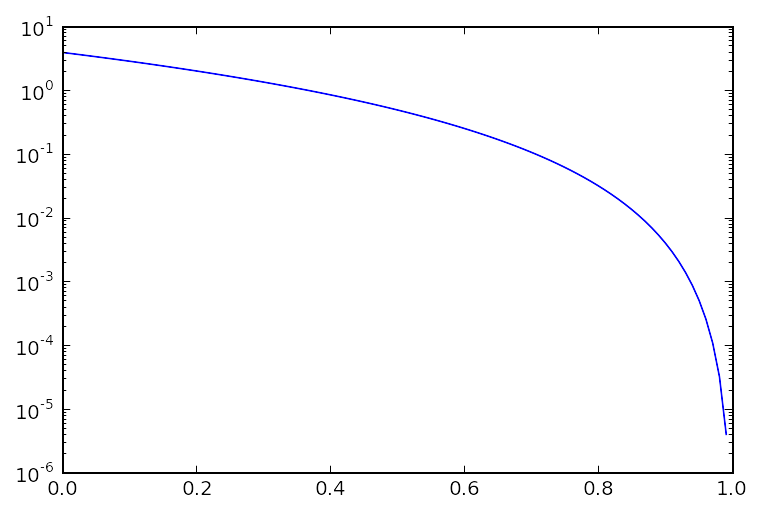

In [34]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

x = np.linspace(0,1,100)
k = 5
plt.semilogy(x, (k-1)*(1-x)**(k-2),'-')